<a href="https://colab.research.google.com/github/EvgeniaKomleva/Requests_Analysis/blob/main/BertRC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 ! pip install pytorch-transformers

     |████████████████████████████████| 176 kB 5.4 MB/s 
     |████████████████████████████████| 1.2 MB 34.4 MB/s 
     |████████████████████████████████| 895 kB 35.9 MB/s 
     |████████████████████████████████| 131 kB 45.5 MB/s 
     |████████████████████████████████| 79 kB 7.4 MB/s 
     |████████████████████████████████| 7.8 MB 45.8 MB/s 
     |████████████████████████████████| 138 kB 48.5 MB/s 
     |████████████████████████████████| 127 kB 48.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig
from pytorch_transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device == torch.device('cpu'):
    print('Using cpu')
else:
    n_gpu = torch.cuda.device_count()
    print('Using {} GPUs'.format(torch.cuda.get_device_name(0)))


Using Tesla K80 GPUs


In [4]:
#from google.colab import files
#uploaded = files.upload()

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import pandas as pd

data = pd.read_csv('/content/drive/MyDrive/data.csv', encoding='utf8')


In [7]:
data.head()

,Unnamed: 0,annotation,label,text
0,0,О трудностях с определением ребенка в ясли,1,"Здравствуйте, Владим Владимирович!\nМеня зовут..."
1,1,О предоставлении места в ДОУ,1,День добрый! Меня зовут Карпова Оксана Констан...
2,2,Об оказании помощи в получении путевки в ДОУ,1,Здравствуйте уважаемый Владимир Владимирович! ...
3,3,О проблемах социально-экономического развития ...,1,"Здравствуйте,уважаемый Владимир Владимирович!П..."
4,4,О проблемах социально-экономического развития ...,1,Здравствуйте уважаемый Владимир Владимирович!П...


In [8]:
sentences = data.text

sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
labels = [[_-1] for _ in data.label.to_numpy()] 


In [9]:
labels_1 = [[1] for _ in range(data.shape[0])]

In [10]:
print(len(labels_1))


20196


In [11]:
print(len(labels))

20196


In [12]:
print(sentences[1])

[CLS] День добрый! Меня зовут Карпова Оксана Константиновна, я являюсь мамой Карповой Валерии Алексеевны 29.10.2011г.р. (5 полных лет). Мы проживаем в городе Екатеринбурге. В феврале 2017г. мы переехали из Орджоникидзевского района в Чкаловский район. В старом районе моя дочь ходила в садик. по переезду в другой район мы встали на учет в отдел образования в Чкаловском районе. В мае месяце было распределение мест в садики. Нам дали место в садике находящемся в другом микро районе до которого можно добраться только на транспорте отстояв в пробках. Мы подали заявление на смену садика. Сейчас уже июнь месяц, садик нам все еще не предоставили. Когда нам будет предоставлено место в садике по месту пребывания? [SEP]


In [13]:
from sklearn.model_selection import train_test_split

train_sentences, test_sentences, train_gt, test_gt = train_test_split(sentences, labels, test_size=0.3)


In [14]:
print(len(train_gt), len(test_gt))

14137 6059


In [15]:
from pytorch_transformers import BertTokenizer, BertConfig


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in train_sentences]
print (tokenized_texts[0])


100%|██████████| 231508/231508 [00:00<00:00, 2146135.98B/s]


['[CLS]', 'п', '##р', '##е', '##з', '##и', '##д', '##е', '##н', '##т', '##у', 'р', '##о', '##с', '##с', '##ии', '##с', '##к', '##о', '##и', 'ф', '##е', '##д', '##е', '##р', '##а', '##ц', '##ии', 'в', '.', 'в', '.', 'п', '##у', '##т', '##и', '##н', '##у', 'у', '##в', '##а', '##ж', '##а', '##е', '##м', '##ы', '##и', 'в', '##л', '##а', '##д', '##и', '##м', '##и', '##р', 'в', '##л', '##а', '##д', '##и', '##м', '##и', '##р', '##ович', '!', '!', '!', '!', 'я', 'к', '##о', '##р', '##ю', '##ка', '##л', '##ов', 'д', '##м', '##и', '##т', '##р', '##ии', 'р', '##ан', '##и', '##е', 'р', '##а', '##б', '##о', '##т', '##а', '##ю', '##щ', '##ии', 'н', '##а', 'з', '##а', '##в', '##о', '##д', '##е', 'у', '##з', '##т', '##м', 'г', '##о', '##р', '##о', '##д', '##а', 'е', '##ка', '##т', '##е', '##р', '##и', '##н', '##б', '##у', '##р', '##г', '.', 'р', '##а', '##б', '##о', '##т', '##а', '##л', 'н', '##а', '12', '-', 'т', '##и', 'м', '##е', '##т', '##р', '##ов', '##о', '##м', 'к', '##а', '##р', '##у', '##с', 

In [16]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(
    input_ids,
    maxlen=100,
    dtype="long",
    truncating="post",
    padding="post"
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]


Выходные данные были обрезаны до нескольких последних строк (5000).
Token indices sequence length is longer than the specified maximum sequence length for this model (552 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (736 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (899 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (639 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (539 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence

In [17]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, train_gt, 
    random_state=42,
    test_size=0.1
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=42,
    test_size=0.1
)

In [18]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

In [19]:
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)


In [20]:

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size=32
)


In [21]:
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=32
)

In [22]:
from pytorch_transformers import AdamW, BertForSequenceClassification
from pytorch_transformers import BertForQuestionAnswering, BertForTokenClassification

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=10)
model.to(device)

100%|██████████| 440473133/440473133 [00:20<00:00, 21141372.76B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [23]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)



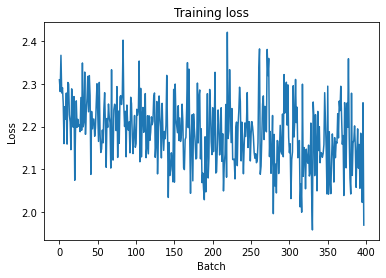

Loss на обучающей выборке: 2.18684
Процент правильных предсказаний на валидационной выборке: 19.31%
Процент правильных предсказаний на валидационной выборке: 19.31%


In [24]:
from IPython.display import clear_output

# Будем сохранять loss во время обучения
# и рисовать график в режиме реального времени
train_loss_set = []
train_loss = 0


# Обучение
# Переводим модель в training mode
model.train()


for step, batch in enumerate(train_dataloader):
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # если не сделать .zero_grad(), градиенты будут накапливаться
    optimizer.zero_grad()
    
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

    train_loss_set.append(loss[0].item())  
    
    # Backward pass
    loss[0].backward()
    
    # Обновляем параметры и делаем шаг используя посчитанные градиенты
    optimizer.step()

    # Обновляем loss
    train_loss += loss[0].item()
    
    # Рисуем график
    clear_output(True)
    plt.plot(train_loss_set)
    plt.title("Training loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.show()
    
print("Loss на обучающей выборке: {0:.5f}".format(train_loss / len(train_dataloader)))


# Валидация
# Переводим модель в evaluation mode
model.eval()

valid_preds, valid_labels = [], []

for batch in validation_dataloader:   
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для валидационных данных.
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)     
    valid_preds.extend(batch_preds)
    valid_labels.extend(batch_labels)

print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))

print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))

In [25]:
print(valid_labels)

[0, 5, 7, 4, 2, 6, 5, 8, 6, 3, 3, 6, 9, 6, 1, 4, 1, 1, 4, 7, 0, 7, 2, 7, 8, 9, 4, 0, 6, 6, 1, 6, 9, 2, 3, 5, 3, 0, 9, 5, 4, 3, 7, 1, 5, 6, 3, 8, 1, 5, 2, 5, 1, 9, 7, 4, 2, 5, 6, 9, 2, 4, 7, 2, 5, 6, 1, 7, 3, 7, 9, 9, 6, 7, 4, 2, 4, 7, 6, 1, 4, 2, 8, 8, 1, 0, 3, 0, 7, 4, 1, 4, 7, 9, 7, 0, 5, 4, 0, 6, 5, 6, 3, 8, 6, 3, 7, 4, 6, 7, 4, 3, 3, 7, 3, 3, 4, 6, 1, 0, 6, 8, 5, 2, 2, 7, 0, 7, 1, 6, 1, 5, 6, 1, 2, 1, 2, 0, 8, 1, 4, 1, 8, 3, 6, 1, 3, 6, 4, 2, 0, 0, 9, 3, 2, 7, 6, 9, 9, 2, 5, 2, 2, 6, 0, 9, 1, 8, 3, 4, 4, 2, 9, 9, 4, 6, 9, 7, 2, 1, 6, 5, 3, 3, 7, 6, 9, 1, 6, 8, 2, 0, 6, 7, 0, 1, 2, 9, 6, 9, 3, 0, 1, 9, 5, 9, 9, 6, 3, 7, 8, 4, 5, 3, 9, 9, 5, 1, 3, 6, 6, 7, 3, 9, 4, 4, 6, 9, 6, 6, 5, 3, 4, 6, 6, 4, 7, 2, 4, 4, 9, 8, 0, 6, 6, 9, 9, 9, 4, 4, 0, 3, 0, 9, 6, 9, 2, 9, 9, 6, 6, 5, 3, 2, 9, 1, 9, 0, 4, 7, 6, 9, 0, 7, 4, 9, 4, 6, 0, 9, 2, 9, 6, 4, 2, 9, 0, 9, 3, 6, 1, 2, 2, 8, 1, 3, 9, 4, 6, 6, 2, 8, 7, 0, 9, 4, 4, 5, 1, 9, 8, 6, 9, 2, 4, 3, 7, 9, 6, 2, 4, 2, 6, 1, 2, 2, 1, 6, 1, 7, 2, 1, 6, 

In [33]:
print(valid_preds)

[6, 8, 6, 8, 6, 6, 8, 8, 6, 6, 6, 8, 6, 6, 6, 8, 0, 6, 0, 7, 6, 8, 8, 7, 8, 8, 8, 6, 6, 9, 8, 6, 8, 6, 6, 6, 6, 6, 8, 8, 8, 9, 7, 3, 6, 6, 6, 8, 6, 6, 8, 3, 6, 8, 8, 6, 6, 6, 6, 8, 6, 0, 6, 0, 7, 6, 8, 7, 6, 8, 8, 6, 6, 6, 7, 6, 8, 8, 8, 6, 6, 6, 8, 8, 7, 6, 6, 6, 6, 8, 8, 6, 8, 6, 8, 6, 8, 7, 8, 6, 3, 8, 6, 8, 6, 6, 7, 8, 8, 9, 6, 8, 9, 8, 8, 6, 8, 8, 6, 6, 6, 8, 7, 6, 8, 8, 6, 9, 6, 6, 7, 6, 8, 7, 8, 8, 6, 6, 8, 6, 9, 8, 8, 6, 6, 8, 6, 6, 3, 6, 0, 6, 6, 6, 6, 6, 6, 8, 6, 8, 8, 7, 8, 6, 9, 6, 3, 8, 6, 6, 8, 8, 6, 9, 6, 6, 9, 6, 3, 8, 6, 8, 6, 6, 7, 6, 8, 8, 6, 8, 7, 6, 8, 6, 6, 6, 8, 7, 6, 9, 0, 6, 8, 9, 6, 6, 6, 8, 8, 6, 8, 8, 6, 8, 6, 7, 8, 6, 7, 6, 6, 8, 8, 8, 6, 8, 6, 6, 8, 3, 8, 8, 8, 6, 9, 6, 8, 0, 6, 6, 6, 8, 6, 6, 6, 8, 8, 8, 3, 8, 6, 8, 6, 7, 6, 6, 8, 8, 6, 6, 8, 6, 6, 8, 6, 3, 6, 6, 8, 3, 6, 8, 0, 6, 7, 6, 9, 6, 0, 9, 8, 8, 8, 3, 6, 6, 6, 6, 8, 7, 6, 6, 6, 8, 7, 3, 8, 6, 8, 6, 6, 8, 7, 6, 8, 9, 8, 6, 8, 8, 8, 9, 8, 6, 8, 0, 8, 7, 0, 6, 6, 6, 6, 6, 6, 6, 9, 8, 6, 8, 8, 8, 8, 

In [27]:
print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))

print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))

Процент правильных предсказаний на валидационной выборке: 19.31%
Процент правильных предсказаний на валидационной выборке: 19.31%


In [28]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in test_sentences]
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

input_ids = pad_sequences(
    input_ids,
    maxlen=100,
    dtype="long",
    truncating="post",
    padding="post"
)

Token indices sequence length is longer than the specified maximum sequence length for this model (1188 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (836 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (639 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1517 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (732 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

In [29]:
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(test_gt)

prediction_data = TensorDataset(
    prediction_inputs,
    prediction_masks,
    prediction_labels
)

prediction_dataloader = DataLoader(
    prediction_data, 
    sampler=SequentialSampler(prediction_data),
    batch_size=32
)


In [30]:
model.eval()
test_preds, test_labels = [], []

for batch in prediction_dataloader:
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для тестовых данных.
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Сохраняем предсказанные классы и ground truth
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)  
    test_preds.extend(batch_preds)
    test_labels.extend(batch_labels)

In [31]:
acc_score = accuracy_score(test_labels, test_preds)
print('Процент правильных предсказаний на отложенной выборке составил: {0:.2f}%'.format(
    acc_score*100
))

Процент правильных предсказаний на отложенной выборке составил: 19.46%


In [32]:
print('Неправильных предсказаний: {0}/{1}'.format(
    sum(test_labels != test_preds),
    len(test_labels)
))

TypeError: ignored

In [34]:

model_wo_finetuning = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=10)
model_wo_finetuning.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [35]:
model_wo_finetuning.eval()
preds_wo_finetuning, labels_wo_finetuning = [], []

for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        logits = model_wo_finetuning(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)  
    preds_wo_finetuning.extend(batch_preds)
    labels_wo_finetuning.extend(batch_labels)

In [36]:
acc_score_wo_finetuning = accuracy_score(labels_wo_finetuning, preds_wo_finetuning)
print('Процент правильных предсказаний на отложенной выборке составил: {0:.2f}%'.format(
    acc_score_wo_finetuning*100
))

Процент правильных предсказаний на отложенной выборке составил: 9.61%


In [37]:
from sklearn.metrics import recall_score, precision_score

print('1 эпоха: точность (precision) {0:.2f}%, полнота (recall) {1:.2f}%'.format(
    precision_score(test_labels, test_preds) * 100,
    recall_score(test_labels, test_preds) * 100
))
 
print('Без дообучения: точность (precision) {0:.2f}%, полнота (recall) {1:.2f}%'.format(
    precision_score(labels_wo_finetuning, preds_wo_finetuning) * 100,
    recall_score(labels_wo_finetuning, preds_wo_finetuning) * 100,
))

ValueError: ignored